# Prepare training data

This notebook prepares the corpus of papers that we will use in training models. 

The metadata is from __, and it helps us filter which papers we will use in our training corpus.

**Table of Contents:**
1. Filter papers based on subdomain labelling
2. Prepare abstract corpus
3. Prepare full-text corpus

Load dependencies.

In [107]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim
import re
import inflect
import matplotlib.pyplot as plt
import numpy as np
import scipy
from math import floor
from random import shuffle
from wordcloud import WordCloud, STOPWORDS
plt.style.use('dark_background')

## 1. Filter papers based on subdomain labelling

Each paper has author-assigned labels. Some of these labels are subdomains of astrophysics, in addition to the generic astrophysics category as well as other domain-level categories. 

Subdomains:
1. Solar and Stellar Astrophysics
2. Cosmology and Nongalactic Astrophysics
3. Astrophysics of Galaxies
4. High Energy Astrophysical Phenomena
5. Earth and Planetary Astrophysics
6. Instrumentation and Methods for Astrophysics

Find each paper's astrophysics subdomain. If it has none, remove it from the data. 

In [110]:
metadata = pd.read_csv('/Volumes/BRIENNAKH/Thesis/data/2020_03_06_arxiv_metadata_astroph/arxiv_metadata_astroph.csv',
                       dtype={'filename': str,
                              'filename_parsed': str,
                              'identifier': str,
                              'updated': str,
                              'doi': str}, 
                       parse_dates=['date_retrieved'])

print('Total number of papers: ' + str(len(metadata)))

# Specify the subdomains we want to target 
subdomains = {'astro-ph.SR': 'Solar and Stellar Astrophysics',
              'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
              'astro-ph.GA': 'Astrophysics of Galaxies',
              'astro-ph.HE': 'High Energy Astrophysical Phenomena',
              'astro-ph.EP': 'Earth and Planetary Astrophysics',
              'astro-ph.IM': 'Instrumentation and Methods for Astrophysics'}

print('\nWe are keeping only papers that have been labeled with any of the following ' 
      + str(len(subdomains.keys())) + ' subdomains:\n' + str(subdomains.values()))

labels = metadata['categories'].str.split(' ')        # Get all labels for each paper
subdomain_labels = []     

for i, _ in enumerate(labels):                         # For each paper,
    temp = []                                          # create a temporary list of subdomain labels and
    has_subdomain_label = False                        # state that the paper has no subdomain labels yet
    for j,_ in enumerate(labels[i]):                   # For each of the paper's labels,
        if labels[i][j] in subdomains.keys():                 # if the paper has a subdomain label
            temp.append(labels[i][j])                  # add the subdomain label to that paper's subdomain labels list
            has_subdomain_label = True                 # and mark that the paper has at least one subdomain label
            
        if j == (len(labels[i]) - 1):                  # When done looking at the last label for that paper,
            if not has_subdomain_label:                # if that paper had no subdomain labels,
                subdomain_labels.append(None)          # add none to the master list
            else:                
                subdomain_labels.append(temp)          # otherwise note its subdomain labels 
                
metadata['subdomains'] = subdomain_labels
papers_with_no_subdomains = np.where(metadata['subdomains'].isna())[0]
print('\nNumber of papers without subdomain labels: ' + str(len(papers_with_no_subdomains)))

Total number of papers: 267794

We are keeping only papers that have been labeled with any of the following 6 subdomains:
dict_values(['Solar and Stellar Astrophysics', 'Cosmology and Nongalactic Astrophysics', 'Astrophysics of Galaxies', 'High Energy Astrophysical Phenomena', 'Earth and Planetary Astrophysics', 'Instrumentation and Methods for Astrophysics'])

Number of papers without subdomain labels: 105283


Our corpus has a total of 267,794 papers. We are going to drop 105,283 papers, because they do not have any astrophysics subdomain labels. 

Will this change the distribution of years?

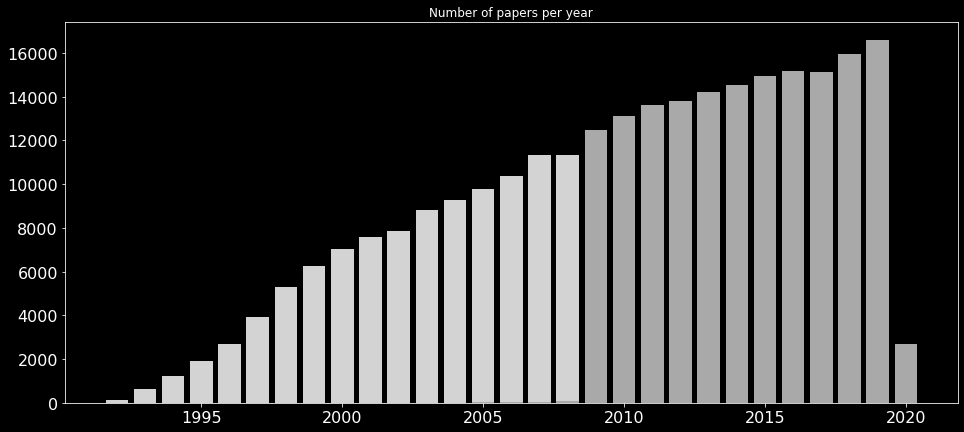

In [112]:
years = pd.to_datetime(metadata['created']).apply(lambda x: x.year)
years_filtered = years.drop(papers_with_no_subdomains)
years_count = years.value_counts()
years_filtered_count = years_filtered.value_counts()

plt.figure(figsize=(16,7))
plt.bar(years_count.keys(), years_count.values, color='lightgray')
plt.bar(years_filtered_count.keys(), years_filtered_count.values, color='darkgray')
plt.title('Number of papers per year')
plt.show()

Looks like in 2009 they realized they should add finer granularity to the field, and introduced subdomain labels then.

A few papers were labeled with astrophysics subdomains in 2007, 2008, etc, but probably because their papers were revised 2009> and the authors had the option to add labels then. 

Check whether there are any papers in or after 2009 that DON'T have subdomain labels.

In [113]:
any(years.take(papers_with_no_subdomains).value_counts().keys() >= 2009)

False

ALL papers in or after 2009 have subdomain labels, so we will include in our corpus papers from 2009-2019. 

**Get abstracts and remove all that are outside 2009-2019.**

Since there are no papers within 2009-2019 that didn't have subdomain labels, we can just select all the papers within this range. 

Set this range to be used when we filter abstracts and full-texts.

In [114]:
papers_out_of_range = [i for i, isInRange in enumerate(years.apply(lambda x: x < 2009 or x > 2019)) if isInRange]
print('Number of papers outside 2009-2019: ' + str(len(papers_out_of_range)))
print('Number of papers within 2009-2019: ' + str(len(metadata) - len(papers_out_of_range)))

Number of papers outside 2009-2019: 108178
Number of papers within 2009-2019: 159616


We have 159,616 papers that qualify for our corpus, based just on the fact that they have astrophysics subdomain labels.

Visualize the subdomain distribution within our corpus.

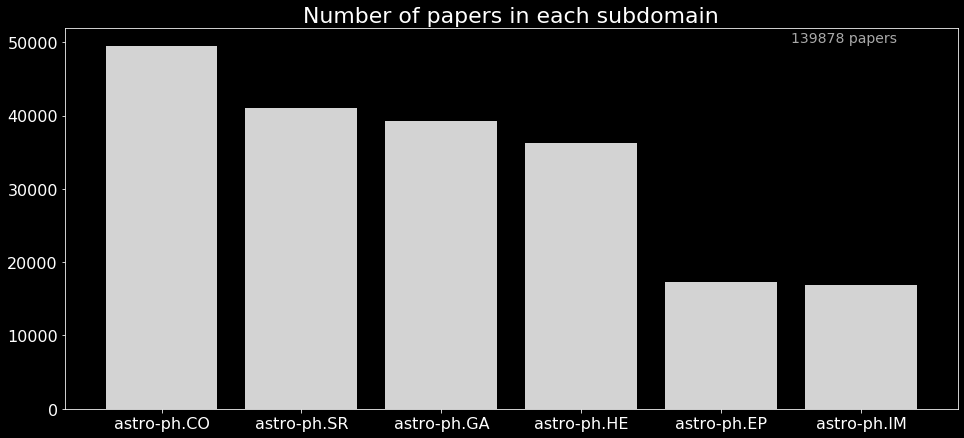

In [115]:
subdomain_distribution = pd.Series([subdomain for subdomains in metadata['subdomains'].drop(papers_out_of_range) for subdomain in subdomains]).value_counts()

plt.figure(figsize=(16,7))
plt.bar(subdomain_distribution.keys(), subdomain_distribution.values, color='lightgray')
plt.title('Number of papers in each subdomain', fontdict=dict(size=22))
plt.text(4.5, 50000, str(len(corpus)) + ' papers', size=14, color='darkgray')
plt.show()

## Prepare abstract corpus

Get abstracts for the 159,616 papers that we are keeping in our corpus. Abstracts are stored in the metadata file.

In [116]:
corpus_temp = metadata.drop(papers_out_of_range)
len(corpus_temp)

159616

We also, for sake of making evaluation more rigid, will remove papers whose primary category is NOT a subdomain of astrophysics. This means we remove it even if it is labeled with astro-ph. We want a subdomain in the primary category, because according to the (info)[https://arxiv.org/help/arxiv_identifier_for_services] the secondary categories are in alphabetical order and thus it would be tough to choose which to use for single-label classification (although multi-label classification may be worth looking into). while we could still use this dataset for triplets, for consistency we will use the same dataset for both — the dataset where all primary categories are subdomains of astrophysics, and nothing else. 

In [117]:
corpus = corpus_temp[corpus_temp['categories'].str.split(' ').apply(lambda x: True if x[0] in subdomains.keys() else False)]
abstracts = [abstract.replace('\n', ' ').strip() for abstract in corpus['abstract']]
abstracts_unfiltered = [abstract.replace('\n', ' ').strip() for abstract in metadata['abstract']]
len(abstracts)

139878

**Distribution of abstract word counts.**

We can see that the most common length of abstracts is 250 words which makes sense given the 250-word limit that journals often have. 

We include the unfiltered abstracts (original corpus) to compare.

*WILL DO THIS FOR FULL TEXTS TOO.*

In [73]:
abstracts_word_count = [len(abstract.split(' ')) for abstract in abstracts]
abstracts_filtered_word_count = [len(abstract.split(' ')) for abstract in abstracts_unfiltered]

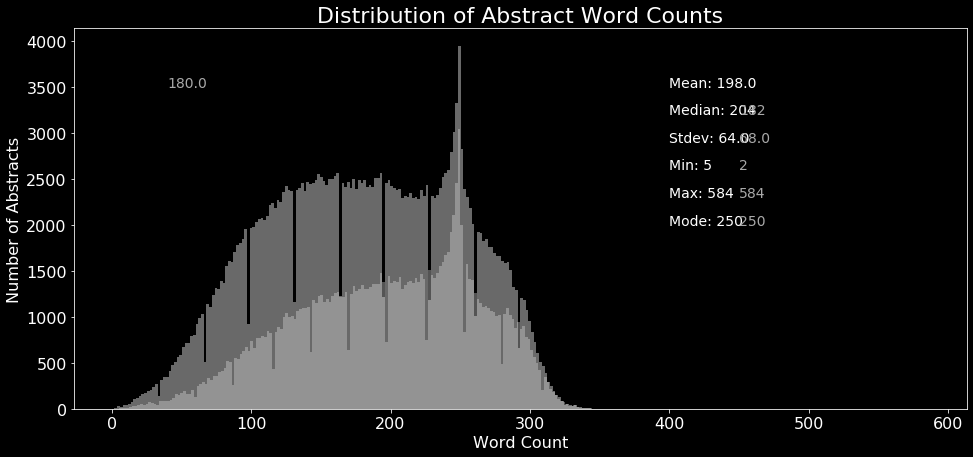

In [105]:
plt.figure(figsize=(16,7))
plt.hist(abstracts_word_count, bins=300, color='darkgray', alpha=0.5)
plt.text(400, 3500, "Mean: " + str(round(np.mean(abstracts_word_count))), size=14)
plt.text(400, 3200, "Median: " + str(int(round(np.median(abstracts_word_count)))), size=14)
plt.text(400, 2900, "Stdev: " + str(round(np.std(abstracts_word_count))), size=14)
plt.text(400, 2600, "Min: " + str(round(np.min(abstracts_word_count))), size=14)
plt.text(400, 2300, "Max: " + str(round(np.max(abstracts_word_count))), size=14)
plt.text(400, 2000, "Mode: " + str(scipy.stats.mode(abstracts_word_count)[0][0]), size=14)
plt.gca().set(ylabel='Number of Abstracts', xlabel='Word Count')
plt.title('Distribution of Abstract Word Counts', fontdict=dict(size=22))
plt.rc('xtick',labelsize=16)
plt.rc('axes',labelsize=16)
plt.rc('ytick',labelsize=16)

plt.hist(abstracts_filtered_word_count, bins=300, color='lightgray', alpha=0.5)
plt.text(40, 3500, str(round(np.mean(abstracts_filtered_word_count))), size=14, color='darkgray')
plt.text(450, 3200, str(int(round(np.median(abstracts_filtered_word_count)))), size=14, color='darkgray')
plt.text(450, 2900, str(round(np.std(abstracts_filtered_word_count))), size=14, color='darkgray')
plt.text(450, 2600, str(round(np.min(abstracts_filtered_word_count))), size=14, color='darkgray')
plt.text(450, 2300, str(round(np.max(abstracts_filtered_word_count))), size=14, color='darkgray')
plt.text(450, 2000, str(scipy.stats.mode(abstracts_filtered_word_count)[0][0]), size=14, color='darkgray')

plt.show()

How to decide optimal number of bins? https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram

One solution is to create a graph that shows every value. Either a dot plot, or a cumulative frequency distribution, which doesn't require any bins. *This took too long to plot.*

If you use too few bins, the histogram doesn't really portray the data very well. If you have too many bins, you get a broken comb look, which also doesn't give a sense of the distribution. The simplest method is to set the number of bins equal to the square root of the number of values you are binning.

I just ended up eyeing it. 

### Tokenize abstracts into our training corpus

Usual steps involved in data preprocessing. 

- Stemming/lemmatizing
- Converting all words to lower case
- Punctuation removal 
- Stop word removal
- Converting numerics to words (e.g. 1990 to one nine nine zero) 

The word2vec/doc2vec are often different. For example, the original word2vec paper and evaluations didn't mention any stemming/lemmatization or stop-word removal and retained punctuation as word-like tokens. The original Paragraph Vector paper and its follow-up seem to do things similarly — with no mention of extra preprocessing before calculating doc-vectors. 

But it's possible that the influence of stopwords and punctuation may be different in word2vec/doc2vec training than in other forms of NLP. 

https://www.ep.liu.se/ecp/131/039/ecp17131039.pdf
- Stop-word removal increases window size.

**This is something I can consider doing in the future. A similar analysis on how slight differences in data preprocessing affect the parameters. But for this thesis we will follow the original approach where we do not perform any stemming/lemmatization or stop-word removal, retain punctuation as word-like tokens.**

**However, performance is strongly correlated with the performance on downstream tasks. So in the end we of course want to test on our practical application.**

Steps that I specified in proposal:
- Convert each paper to lowercase. This avoids the problem of treating words such as "Galaxy" and "galaxy" as two different words. However, this introduces the problem of treating words such as "Newton" and "newton" as the same word when they are in fact two different words. There will be much fewer of the second problem than the first problem. Furthermore, we are going to be able to differentiate between words such as HUBBLE and Hubble since we are keeping all capitalized words as capitalized.
- Remove apostrophes and hyphens. 
- Remove all numbers.

**Here we convert numbers to English words, remove punctuation, and convert to lowercase except acronyms.**

Compare original & preprocessed abstract:

In [118]:
def tokenize(text, include_numbers=True): 
    if include_numbers:
        # Convert numbers to English words
        p = inflect.engine()
        text = re.sub(r'[+-]?\d+(\.\d+)?', lambda m: p.number_to_words(m.group()), text)
    
    # Tokenize the text, removing accents
    tokens = list(gensim.utils.tokenize(text, deacc=True))
    
    # Lowercase all tokens except those that are longer than one letter & entirely capitalized (usually acronyms)
    tokens = [token.lower() if (not token.isupper() and len(token) > 1) else token for token in tokens]
    return np.array(tokens)

In [76]:
print('ORIGINAL\n' + abstracts[1])
print('\nPREPROCESSED\n' + str(tokenize(abstracts[1])))

ORIGINAL
The dark cloud Lynds 1622 is one of a few specific sites in the Galaxy where, relative to observed free-free and vibrational dust emission, there is a clear excess of microwave emission. In order to constrain models for this microwave emission, and to better establish the contribution which it might make to ongoing and near-future microwave background polarization experiments, we have used the Green Bank Telescope to search for linear polarization at 9.65 Ghz towards Lynds 1622. We place a 95.4% upper limit of 88 micro-Kelvin (123 micro-Kelvin at 99.7 confidence) on the total linear polarization of this source averaged over a 1'.3 FWHM beam. Relative to the observed level of anomalous emission in Stokes I these limits correspond to fractional linear polarizations of 2.7% and 3.5%.

PREPROCESSED
['the' 'dark' 'cloud' 'lynds' 'one' 'thousand' 'six' 'hundred' 'and'
 'twenty' 'two' 'is' 'one' 'of' 'a' 'few' 'specific' 'sites' 'in' 'the'
 'galaxy' 'where' 'relative' 'to' 'observed'

Preprocess all abstracts and save the tokens, so that we don't need to do this every time we train the model cuz we will train the model many times.

In [77]:
for i, abstract in enumerate(abstracts):
    filename = corpus['filename_parsed'].iloc[i] + '.npy'
    np.save('/Volumes/BRIENNAKH/Thesis/data/2020_06_09_abstract_tokens/' + filename, tokenize(abstract))

Now each preprocessed abstract has its own .npy file in the "../data/2020_06_03_abstract_tokens/" folder. To work with them in the future, load using numpy.

Tokenize without numbers.

In [120]:
for i, abstract in enumerate(abstracts):
    filename = corpus['filename_parsed'].iloc[i] + '.npy'
    include_numbers = False
    np.save('/Volumes/BRIENNAKH/Thesis/data/2020_06_12_abstract_tokens/' + filename, tokenize(abstract, include_numbers))

## Additional data exploration

Visualize the most used words in each category of labels. 

In [78]:
def generate_word_cloud(text):
    cloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      collocations=False,
                      width=2500,
                      height=1800).generate(" ".join(text))
    return cloud

clouds = []
for category in subdomains.keys():
    text = corpus[corpus['categories'].str.contains(category)]['abstract']
    cloud = generate_word_cloud(text)
    clouds.append(cloud)

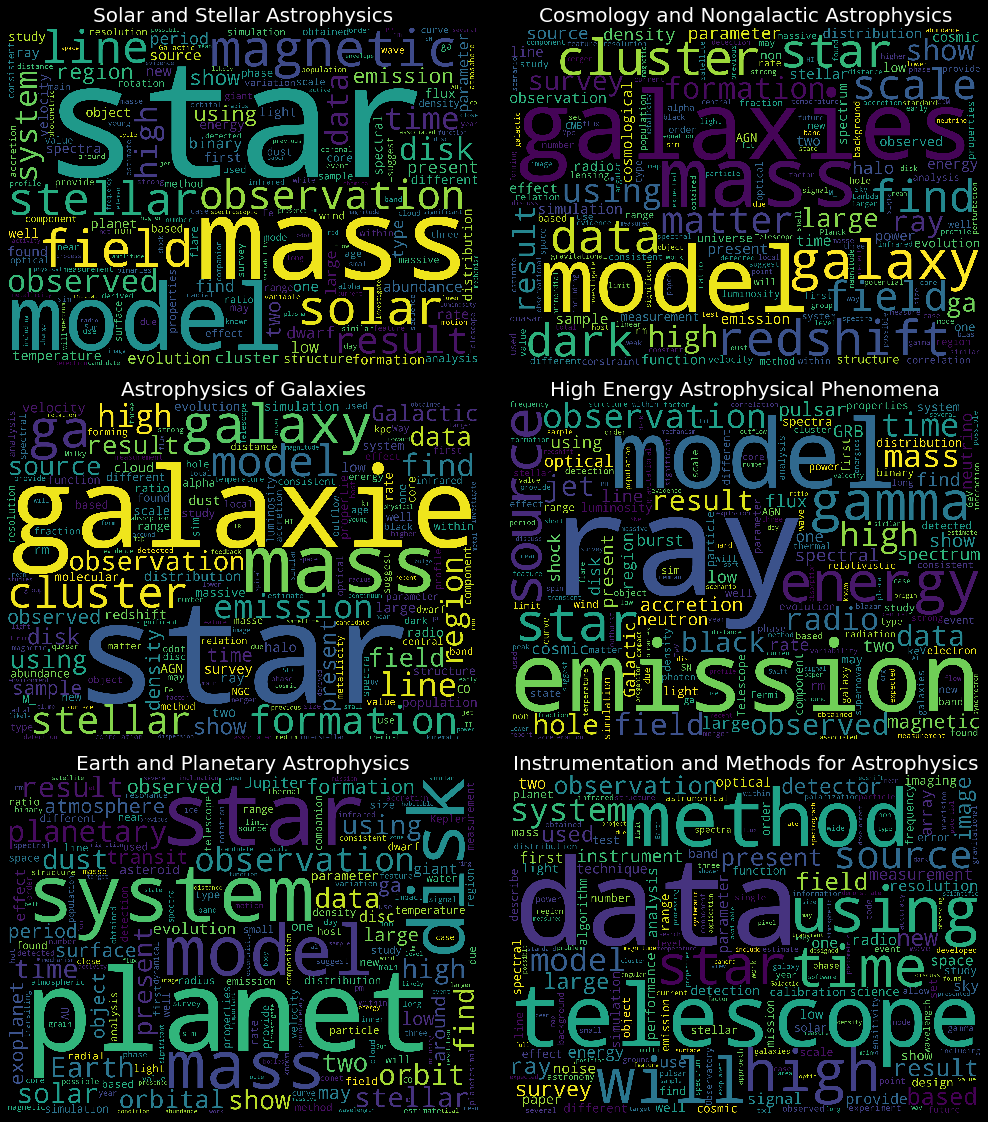

In [106]:
fig, axarr = plt.subplots(nrows=3, ncols=2, figsize=(18, 20))
fig.subplots_adjust(hspace=0.1, wspace=0)

for i, ax in enumerate(axarr.reshape(-1)):
    ax.set_title(subdomains[list(subdomains.keys())[i]], fontsize=20)
    ax.axis('off')
    ax.imshow(clouds[i])

Distribution of the number of labels each paper has. 

In [96]:
labels = []
for doc in [x for x in corpus['categories'].str.split(' ')]:
    cats = []
    for cat in doc:
        if cat in subdomains.keys():
            cats.append(cat)
    labels.append(cats)
label_count = pd.Series([len(x) for x in labels]).value_counts()
label_count

1    104697
2     31771
3      3144
4       196
5        63
6         7
dtype: int64